Italy house prices prediction.
Dataset https://www.kaggle.com/datasets/tommasoramella/italy-house-prices/data


In [72]:

path = "italy-house-prices"

print("Path to dataset files:", path)

Path to dataset files: italy-house-prices


In [73]:
import os
PATH = path+"/versions/8"
os.listdir(PATH)

['limits_IT_municipalities.geojson',
 'limits_IT_provinces.geojson',
 'limits_IT_regions.geojson',
 'rents_clean.csv',
 'rent_raw.csv',
 'sale_clean.csv',
 'sale_raw.csv']

In [74]:
import pandas as pd
import numpy as np
from deep_translator import GoogleTranslator
import json
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
from pandas_geojson import read_geojson

In [75]:
df_rent_clean = pd.read_csv(PATH + "/rents_clean.csv")
df_rent_clean.head(3)

,regione,citta,quartiere,prezzo,datetime,posti auto,bagni per stanza,bagni,stanze,ultimo piano,...,giardino privato,impianto allarme,portiere,piscina,villa,intera proprieta,appartamento,attico,loft,mansarda
0,NaN,Milano,Centrale,1800.0,2023-07-03,1,0.333333,1.0,3.0,0,...,0,0,0,0,0,0,1,0,0,0
1,NaN,Torino,Santa Rita,450.0,2023-07-03,0,0.500000,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
2,NaN,Padova,Prato della Valle - Pontecorvo,3200.0,2023-07-03,1,NaN,3.0,NaN,0,...,0,0,0,0,0,0,1,0,0,0


DATA CLEANING

In [76]:
## translate columns in English
def translate(italian_input):
    return GoogleTranslator(source="it", target="en").translate(italian_input)

columns_translated = [translate(c) for c in df_rent_clean.columns]
columns_translated[12], columns_translated[-1] = "sea_view", "mansard"
columns_translated = [c.replace(" ", "_") for c in columns_translated]
df_rent_clean.columns = columns_translated
df_rent_clean.head(3)


,region,city,quarter,price,datetime,parking_spaces,Bathrooms_per_room,bathrooms,rooms,top_floor,...,private_garden,alarm_system,doorman,pool,villa,full_ownership,apartment,penthouse,loft,mansard
0,NaN,Milano,Centrale,1800.0,2023-07-03,1,0.333333,1.0,3.0,0,...,0,0,0,0,0,0,1,0,0,0
1,NaN,Torino,Santa Rita,450.0,2023-07-03,0,0.500000,1.0,2.0,1,...,0,0,0,0,0,0,1,0,0,0
2,NaN,Padova,Prato della Valle - Pontecorvo,3200.0,2023-07-03,1,NaN,3.0,NaN,0,...,0,0,0,0,0,0,1,0,0,0


12500000.0


(array([  428.,   305.,  2651.,  9720., 15593., 13774., 11825.,  9563.,
         6844.,  6593.,  3491.,  4807.,  3589.,  2665.,  3765.,  1998.,
         1785.,  2288.,  1048.,  2251.,   686.,  1024.,   783.,   530.,
          128.,  1730.,   399.,   473.,   585.,   246.,  1152.,   245.,
          350.,   329.,   112.,   782.,   149.,   245.,   186.,   153.,
          643.,    56.,    93.,    93.,    68.,   387.,    51.,    27.,
           72.,    53.]),
 array([1.00000e+00, 1.00960e+02, 2.00920e+02, 3.00880e+02, 4.00840e+02,
        5.00800e+02, 6.00760e+02, 7.00720e+02, 8.00680e+02, 9.00640e+02,
        1.00060e+03, 1.10056e+03, 1.20052e+03, 1.30048e+03, 1.40044e+03,
        1.50040e+03, 1.60036e+03, 1.70032e+03, 1.80028e+03, 1.90024e+03,
        2.00020e+03, 2.10016e+03, 2.20012e+03, 2.30008e+03, 2.40004e+03,
        2.50000e+03, 2.59996e+03, 2.69992e+03, 2.79988e+03, 2.89984e+03,
        2.99980e+03, 3.09976e+03, 3.19972e+03, 3.29968e+03, 3.39964e+03,
        3.49960e+03, 3.59956e+0

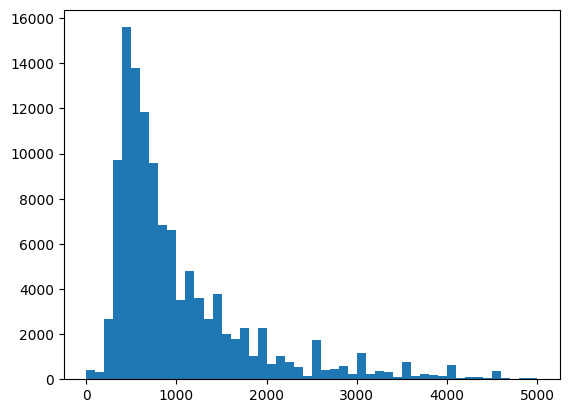

In [77]:
## drop outliers
print(df_rent_clean["price"].max())
df_rent_clean = df_rent_clean.loc[df_rent_clean["price"] < 5000]
plt.hist(df_rent_clean["price"], bins=50)

In [78]:
## clean datetime
import datetime
from datetime import date
today = np.datetime64(date.today())
full_calendar = pd.DataFrame(pd.date_range(start="2023-01-01", end=today), columns=["datetime"])

df_rent_clean["datetime"] = pd.to_datetime(df_rent_clean["datetime"])
df_rent_clean = df_rent_clean.loc[(df_rent_clean["datetime"] > "2023-01-01") & (df_rent_clean["datetime"] < today)]
df_rent_clean["month"] = df_rent_clean["datetime"].dt.to_period("M").dt.start_time
df_rent_clean["week"] = df_rent_clean["datetime"].dt.to_period("W").dt.start_time
df_rent_clean["week"]

0        2023-07-03
1        2023-07-03
2        2023-07-03
4        2023-05-29
5        2023-11-27
            ...    
126232   2023-07-24
126233   2023-07-24
126234   2023-07-24
126235   2023-07-24
126236   2023-07-24
Name: week, Length: 113226, dtype: datetime64[ns]

DATA EXPLORATION

In [79]:
df_rent_clean.region.value_counts().sort_values(ascending=False)

region
lombardia                23516
lazio                    18265
piemonte                 14967
emilia-romagna           12347
veneto                    7363
toscana                   7058
campania                  6381
liguria                   5569
sicilia                   5185
marche                    2380
puglia                    2372
umbria                    2368
abruzzo                   1617
trentino-alto-adige       1243
sardegna                   784
calabria                   675
basilicata                 250
friuli-venezia-giulia      248
valle-d-aosta              243
molise                     240
emilia-Romagna              66
trieste                     25
catanzaro                   21
genova                       7
palermo                      5
bari                         4
l-aquila                     3
napoli                       3
Liguria                      2
torino                       2
milano                       2
ancona                       2
v

Text(0.5, 1.0, 'Squared meters')

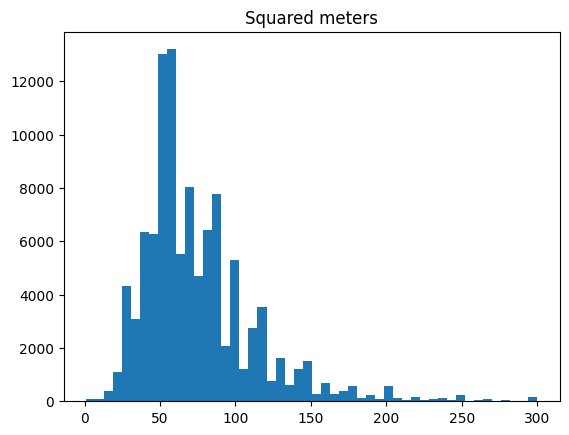

In [80]:
## sq. meters
plt.hist(df_rent_clean["surface"], bins=50)
plt.title("Squared meters")

In [81]:
## furnished
df_rent_clean["furnished"].value_counts(normalize=True)*100

furnished
1    72.502782
0    27.497218
Name: proportion, dtype: float64

{'Apartments': 103981, 'Villa': 4172, 'Attic': 2959, 'Loft': 397}


Text(0.5, 1.0, 'Flat type')

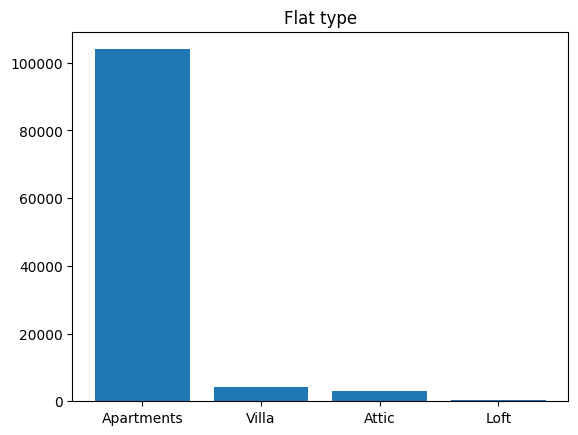

In [82]:
## type of building
types = {
    "Apartments": len(df_rent_clean.loc[df_rent_clean["apartment"] == 1]),
    "Villa": len(df_rent_clean.loc[df_rent_clean["villa"] == 1]),
    "Attic": len(df_rent_clean.loc[df_rent_clean["penthouse"] == 1]) + len(df_rent_clean.loc[df_rent_clean["mansard"] == 1]),
    "Loft": len(df_rent_clean.loc[df_rent_clean["loft"] == 1])
}
print(types)
plt.bar(types.keys(), types.values())
plt.title("Flat type")

GEOGRAPHICAL ANALYSIS

Text(0, 0.5, 'Region')

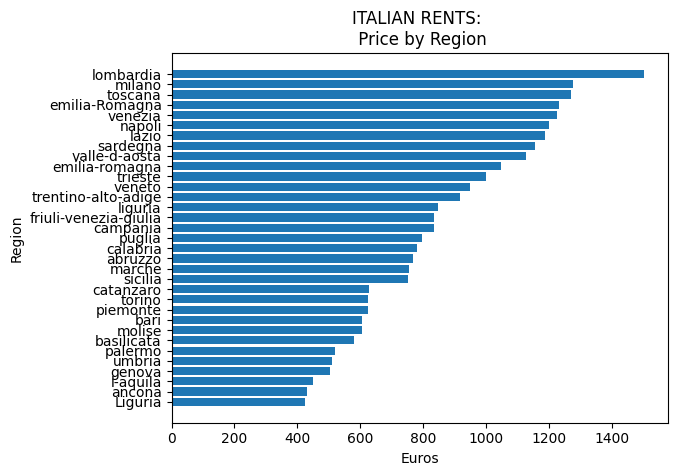

In [83]:
## price by region
price_by_region = df_rent_clean["price"].groupby(df_rent_clean["region"]).mean().sort_values(ascending=True)
fig1, ax = plt.subplots()
ax.barh(price_by_region.index, price_by_region)
ax.set_title(f"ITALIAN RENTS: \n Price by Region")
ax.set_xlabel("Euros")
ax.set_ylabel("Region")

In [84]:
# get centroids coordinates from geojson
def get_area_centroids(geo_file):
    coords = gpd.read_file(geo_file)
    # Convert to a projected CRS (e.g., EPSG:3857 or EPSG:3035)
    coords = coords.to_crs(epsg=3857)
    centroids = coords["geometry"].centroid
    coords = coords.to_crs(epsg=4326)
    lon = centroids.x
    lat = centroids.y
    coords["lat"], coords["lon"] = lat, lon
    return coords
    

In [85]:
regions_json = "italy-house-prices/versions/8/limits_IT_regions.geojson"
provs_json = "italy-house-prices/versions/8/limits_IT_provinces.geojson"
municipalities_json = "italy-house-prices/versions/8/limits_IT_municipalities.geojson"

region_coords = get_area_centroids(regions_json)
provinces_coords = get_area_centroids(provs_json)
municipalities_coords = get_area_centroids(municipalities_json)


In [86]:
## group by province
prices_by_province = df_rent_clean.merge(provinces_coords, left_on="city", right_on="prov_name", how="left")
prices_by_province = prices_by_province.groupby(["city", "lat", "lon"]).agg({"price": "mean"}).reset_index().sort_values(by=["price"], ascending=True)
prices_by_province = prices_by_province[["city", "lat", "lon", "price"]]
prices_by_province = prices_by_province.dropna(subset=["lat", "lon"])

# plot prices by area
def map_prices_plot(prices_by_area):
    fig = px.scatter_map(
        prices_by_area, lat="lat", lon="lon",
        hover_name="city",
        hover_data=["price"],
        color="price",
        color_continuous_scale="turbo",
        range_color=(0, 2000),
        size="price",
        zoom=5,
        center=dict(lat=41.8719, lon=12.5674),
        opacity=0.5,
        labels={"price": "Price in €"},
        height=700, width=700
    )

    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(margin={"r":5, "t":0, "l":0, "b":0})
    fig.show()

map_prices_plot(prices_by_province)

In [87]:
# group by municipality
prices_by_municipalities = df_rent_clean.merge(municipalities_coords, left_on='city', right_on='name', how='left')
prices_by_municipalities = prices_by_municipalities.groupby(["city", "lat", "lon"]).agg({'price': 'mean'}).reset_index().sort_values(by=['price'], ascending=True)
prices_by_municipalities = prices_by_municipalities[['city', 'lat', 'lon', 'price']]
prices_by_municipalities = prices_by_municipalities.dropna(subset=['lat', 'lon'])

map_prices_plot(prices_by_municipalities)